In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

import seaborn as sns
import matplotlib.pyplot as plt

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)
    
path_to_hnets = './Models/Models_HNET'

# Data Analysis - Synthetic Data Generation

In [3]:
data_path_exp0_v0 = './Data/Sim_Data_'+'Experiment60_sorted'+'.pkl'
with open(os.path.join(data_path_exp0_v0), 'rb') as fp:
    data_exp0_v0 = pickle.load(fp)

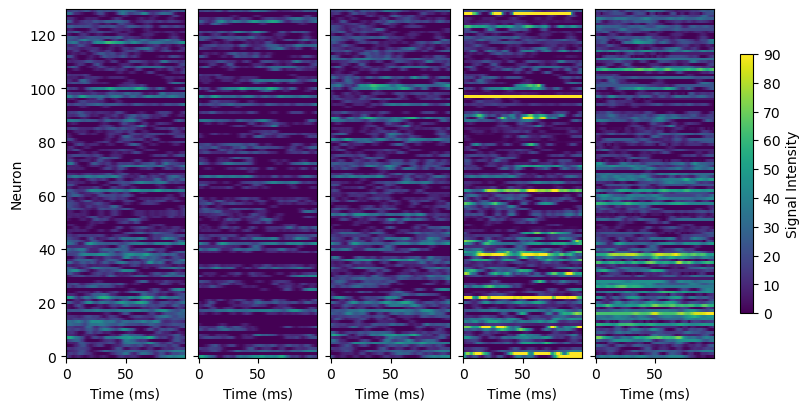

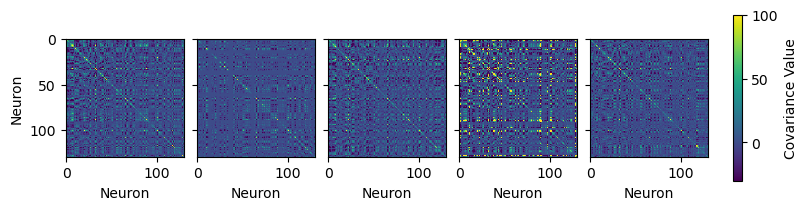

In [4]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Prepare the figure and axes
fig, ax = plt.subplots(figsize=(8, 4), ncols=5, nrows=1, constrained_layout=True, sharex=True, sharey=True)

# Extract the data arrays
data_arrays = [
    xr.DataArray(data_exp0_v0['Data_0_1'][0][1, :, :], dims=['time', 'neuron']),
    xr.DataArray(data_exp0_v0['Data_1_1'][0][1, :, :], dims=['time', 'neuron']),
    xr.DataArray(data_exp0_v0['Data_2_1'][0][1, :, :], dims=['time', 'neuron']),
    xr.DataArray(data_exp0_v0['Data_3_1'][0][1, :, :], dims=['time', 'neuron']),
    xr.DataArray(data_exp0_v0['Data_4_1'][0][1, :, :], dims=['time', 'neuron'])
]

# Determine the common color scale range
vmin = min([arr.min() for arr in data_arrays])
vmax = max([arr.max() for arr in data_arrays])

# Plot each data array
titles = ['Baseline', 'Removed Neurons', 'Shuffled Neurons', 'Added Gain', 'Added Offset']
for i, data in enumerate(data_arrays):
    im = data.transpose('neuron', 'time').plot(ax=ax[i], vmin=vmin, vmax=90, cmap='viridis', add_colorbar=False) #cbar_kwargs={'label': 'Signal Intensity'})
    #ax[i].set_title(titles[i],fontsize=25)
    ax[i].set_xlabel('Time (ms)')#, fontsize=20)
    if i == 0:
        ax[i].set_ylabel('Neuron')#, fontsize=20)
    else:
        ax[i].set_ylabel('')

        
# Add a single colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Signal Intensity')#,  fontsize=20)
cbar.set_ticks(np.linspace(0, 90, num=10))

# Adjust layout and show the plot
#plt.suptitle('Neural Data Heatmaps', fontsize=40)
plt.show()

# Create a separate figure for the covariance matrices
fig_cov, ax_cov = plt.subplots(figsize=(8, 2), ncols=5, nrows=1, constrained_layout=True, sharex=True, sharey=True)

# Plot each covariance matrix in the new figure
for i, data in enumerate(data_arrays):
    data_centered = data - np.mean(data, axis=0)
    covariance_matrix = np.cov(data_centered, rowvar=False)
    im_cov = ax_cov[i].imshow(covariance_matrix, cmap='viridis', aspect='equal', vmin=-30, vmax=100)
    #ax_cov[i].set_title(f'{titles[i]} Covariance', fontsize=20)
    ax_cov[i].set_xlabel('Neuron')#, fontsize=20)
    
    if i == 0:
        ax_cov[i].set_ylabel('Neuron')#, fontsize=20)
    else:
        ax_cov[i].set_ylabel('')

# Add a colorbar for the covariance matrices
cbar_cov = fig_cov.colorbar(im_cov, ax=ax_cov, orientation='vertical', fraction=0.02, pad=0.04)
cbar_cov.set_label('Covariance Value')#,  fontsize=20)

# Show the covariance matrices
#plt.suptitle('Covariance Matrices', fontsize=40)
plt.show()


# Experiment 0: Assessing Catastrophic Forgetting

### To have more robust results, once data was generated we permuted the task order 3 times, always keeping the baseline as the first task.

#### Here the first version of the experiment, we will call it V0.

In [5]:
experiment0_hnet_v0 = 'Experiment76'
models_exp0_hnet_v0 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v0)))


path_results_exp0_v0 = './Results/' + experiment0_hnet_v0
with open(os.path.join(path_results_exp0_v0 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v0 = pickle.load(fp)

In [6]:
df_exp0_v0 = build_catas_forg_df(results_hnet_exp0_v0, data_exp0_v0, models_exp0_hnet_v0, experiment0_hnet_v0)

In [7]:
def plot_catas_forg(df_plot):
    set_plot_style()
    # Create the bar plot
    plt.figure()

    sns.barplot(data=df_plot, x='Model', y='R2', hue='Name')#, palette=custom_palette,)#, color = 'Name', ci=None)  # ci=None to remove confidence intervals

    #plt.title('R2 Value by Model and Dataset during CL with Hypernetworks', fontsize=20)

    plt.ylabel('R2 Value')
    plt.xlabel('')

    new_labels = ['Trained Task 1', 'Trained Task 2', 'Trained Task 3', 'Trained Task 4', 'Trained Task 5']  # New labels for x-axis

    plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
    plt.yticks(fontsize = 12)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.ylim([0.5,0.9])
    plt.show() 

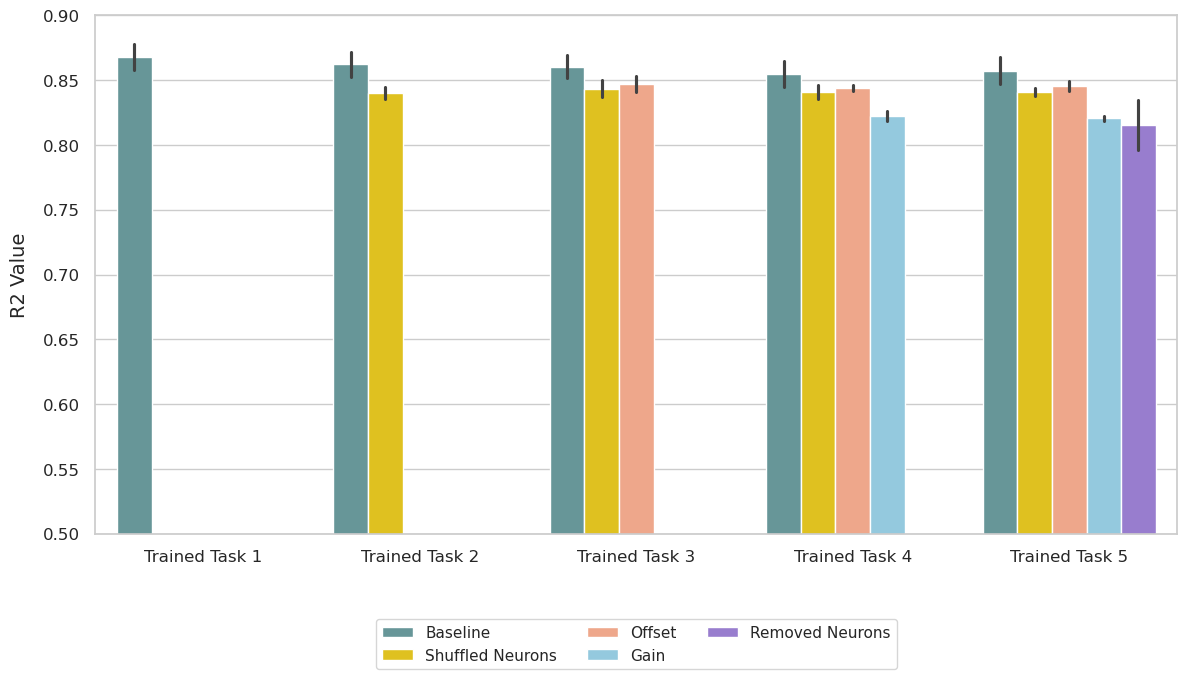

In [8]:
plot_catas_forg(df_exp0_v0)

#### Here the second version of the experiment, we will call it V1.

In [9]:
experiment0_hnet_v1 = 'Experiment78'
models_exp0_hnet_v1 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v1)))


path_results_exp0_v1 = './Results/' + experiment0_hnet_v1
with open(os.path.join(path_results_exp0_v1 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v1 = pickle.load(fp)

data_path_exp0_v1 = './Data/Sim_Data_'+'Experiment60_sorted_v2'+'.pkl'
with open(os.path.join(data_path_exp0_v1), 'rb') as fp:
    data_exp0_v1 = pickle.load(fp)


In [10]:
df_exp0_v1 = build_catas_forg_df(results_hnet_exp0_v1, 
                                 data_exp0_v1, 
                                 models_exp0_hnet_v1, 
                                 experiment0_hnet_v1)

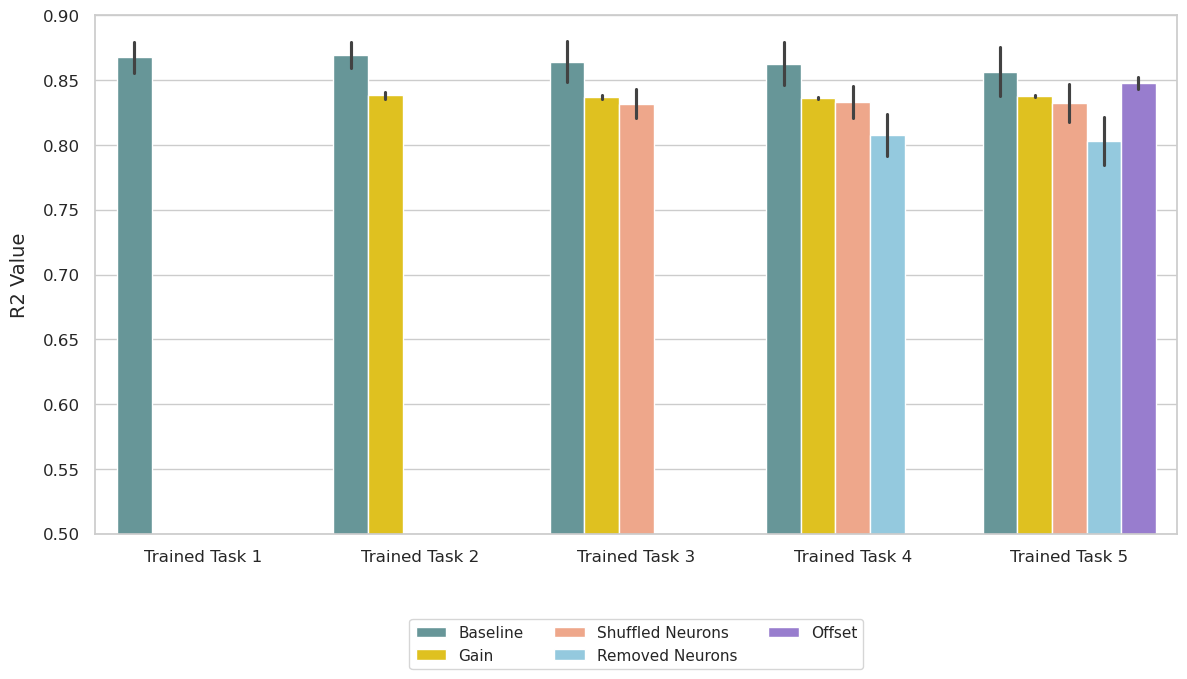

In [11]:
plot_catas_forg(df_exp0_v1)

#### Here the third version of the experiment, we will call it V2.

In [12]:
experiment0_hnet_v2 = 'Experiment79_moreB'
models_exp0_hnet_v2 = np.sort(os.listdir(os.path.join(path_to_hnets, 
                                                      experiment0_hnet_v2)))


path_results_exp0_v2 = './Results/' + experiment0_hnet_v2
with open(os.path.join(path_results_exp0_v2 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v2 = pickle.load(fp)

data_path_exp0_v2 = './Data/Sim_Data_'+'Experiment60_sorted_v3'+'.pkl'
with open(os.path.join(data_path_exp0_v2), 'rb') as fp:
    data_exp0_v2 = pickle.load(fp)


In [13]:
df_exp0_v2 = build_catas_forg_df(results_hnet_exp0_v2, 
                                 data_exp0_v2, 
                                 models_exp0_hnet_v2, 
                                 experiment0_hnet_v2)

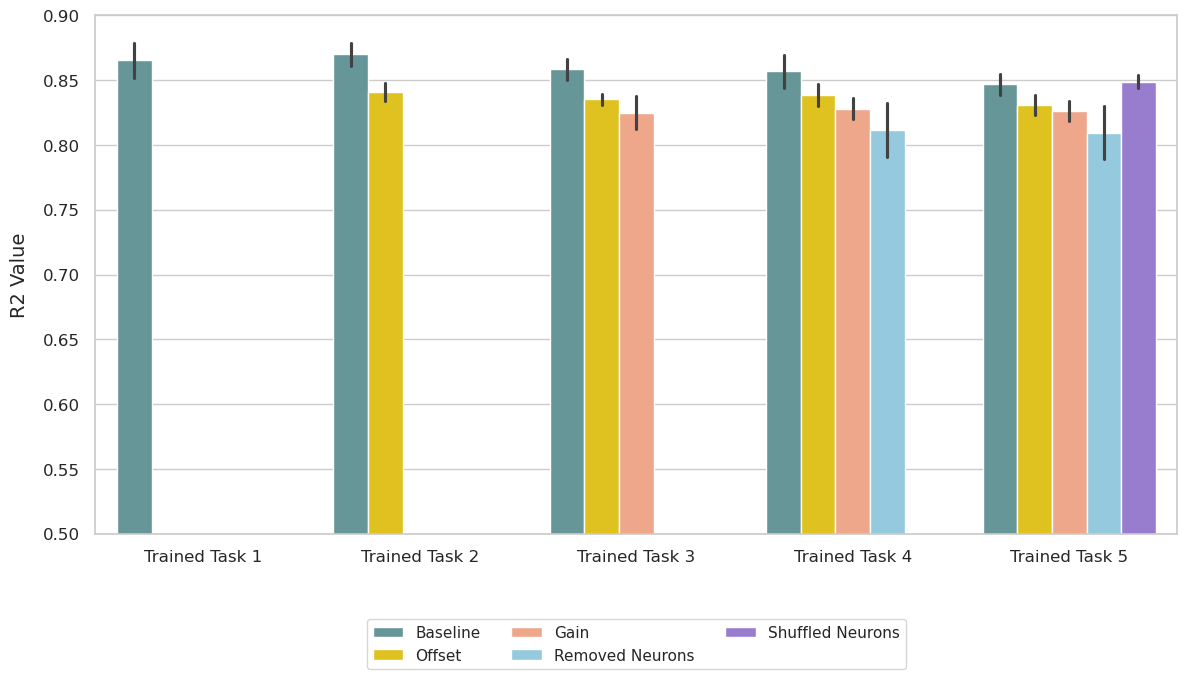

In [14]:
plot_catas_forg(df_exp0_v2)

# Experiment 1: Comparison with other methods

In [15]:
experiment1_control = 'Experiment76_control'
models_exp1_control = np.sort(os.listdir(os.path.join(path_to_hnets, experiment1_control)))

path_results_exp1_control = './Results/' + experiment1_control
with open(os.path.join(path_results_exp1_control +'.pkl'), 'rb') as fp:
    results_exp1_control = pickle.load(fp)

data_path_exp1_control = './Data/Sim_Data_'+'Experiment60_sorted'+'.pkl'

with open(os.path.join(data_path_exp1_control), 'rb') as fp:
    data_exp1_control = pickle.load(fp)

In [16]:
path_to_RNN = './Models/Models_RNN_Control'
experiment1_RNN = 'Experiment77_RNN_control'
models_exp1_RNN = np.sort(os.listdir(os.path.join(path_to_RNN, 'Experiment77')))

path_results_exp1_RNN = './Results/' + experiment1_RNN
with open(os.path.join(path_results_exp1_RNN +'.pkl'), 'rb') as fp:
    results_exp1_RNN = pickle.load(fp)

data_path_exp1_RNN = './Data/Sim_Data_Experiment60_sorted_first5'+'.pkl'

with open(os.path.join(data_path_exp1_RNN), 'rb') as fp:
    data_exp1_RNN = pickle.load(fp)

In [17]:
path_to_RNN_complex = './Models/Models_RNN_Control'
experiment1_RNN_complex = 'Experiment77_complexRNN'
models_exp1_RNN_complex = np.sort(os.listdir(os.path.join(path_to_RNN_complex, 'Experiment77_complexRNN')))

path_results_exp1_RNN_complex = './Results/' + experiment1_RNN_complex
with open(os.path.join(path_results_exp1_RNN_complex +'.pkl'), 'rb') as fp:
    results_exp1_RNN_complex = pickle.load(fp)

data_path_exp1_RNN_complex = './Data/Sim_Data_Experiment60_sorted_first5'+'.pkl'

with open(os.path.join(data_path_exp1_RNN_complex), 'rb') as fp:
    data_exp1_RNN_complex = pickle.load(fp)

In [18]:
experiment1_RNN_v1 = 'Experiment92_RNN_control'
models_exp1_RNN_v1 = np.sort(os.listdir(os.path.join(path_to_RNN, 'Experiment92')))

path_results_exp1_RNN_v1 = './Results/' + experiment1_RNN_v1
with open(os.path.join(path_results_exp1_RNN_v1 +'.pkl'), 'rb') as fp:
    results_exp1_RNN_v1 = pickle.load(fp)

data_path_exp1_RNN_v1 = './Data/Sim_Data_Experiment60_sorted_first5_v2'+'.pkl'

with open(os.path.join(data_path_exp1_RNN_v1), 'rb') as fp:
    data_exp1_RNN_v1 = pickle.load(fp)

In [19]:
experiment1_RNN_v2 = 'Experiment93_RNN_control'
models_exp1_RNN_v2 = np.sort(os.listdir(os.path.join(path_to_RNN, 'Experiment93')))

path_results_exp1_RNN_v2 = './Results/' + experiment1_RNN_v2
with open(os.path.join(path_results_exp1_RNN_v2 +'.pkl'), 'rb') as fp:
    results_exp1_RNN_v2 = pickle.load(fp)

data_path_exp1_RNN_v2 = './Data/Sim_Data_Experiment60_sorted_first5_v3'+'.pkl'

with open(os.path.join(data_path_exp1_RNN_v2), 'rb') as fp:
    data_exp1_RNN_v2 = pickle.load(fp)

In [20]:
def build_results_df_short(results):# Initialize an empty list to store all rows across experiments
    rows = []


    # Loop over each dataset in the current experiment
    for key, value in results.items():
        # Create a new row for each dataset, including the experiment index
        row = {**value, 'dataset': key}  # Add the dataset key and experiment index as new columns
        rows.append(row)

    # Create a single DataFrame from all rows
    df = pd.DataFrame(rows)
    return df

In [21]:
df_exp1_RNN_complex = build_results_df_short(results_exp1_RNN_complex)

In [22]:
df_exp1_RNN = build_results_df_short(results_exp1_RNN)
df_exp1_RNN_v1 = build_results_df_short(results_exp1_RNN_v1)
df_exp1_RNN_v2 = build_results_df_short(results_exp1_RNN_v2)

Define the dataframes for each experiment. 

In [23]:
df_exp1_control = build_result_df(results_exp1_control, data_exp1_control)
df_exp0_hnet_v0 = build_result_df(results_hnet_exp0_v0, data_exp0_v0)
df_exp0_hnet_v1 = build_result_df(results_hnet_exp0_v1, data_exp0_v1)
df_exp0_hnet_v2 = build_result_df(results_hnet_exp0_v2, data_exp0_v2)

Keep only the tasks learned and sort the dataframes in the order of the learned tasks.

In [24]:
# For the control experiment
df_exp1_control_new = df_exp1_control.loc[df_exp1_control.New_Task == True].reset_index()
df_exp1_control_new.sort_values(by='Dataset', inplace=True)
df_exp1_control_new = df_exp1_control_new.reset_index().drop(columns = ['index'])

# For the first version of the experiment
df_exp0_hnet_new_v0 = df_exp0_hnet_v0.loc[df_exp0_hnet_v0.New_Task == True].reset_index()
df_exp0_hnet_new_v0.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v0 = df_exp0_hnet_new_v0.reset_index()

# For the second version of the experiment
df_exp0_hnet_new_v1 = df_exp0_hnet_v1.loc[df_exp0_hnet_v1.New_Task == True].reset_index()
df_exp0_hnet_new_v1.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v1 = df_exp0_hnet_new_v1.reset_index()

# For the third version of the experiment
df_exp0_hnet_new_v2 = df_exp0_hnet_v2.loc[df_exp0_hnet_v2.New_Task == True].reset_index()
df_exp0_hnet_new_v2.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v2 = df_exp0_hnet_new_v2.reset_index()



In [25]:
import matplotlib.pyplot as plt

def plot_learning_curves(df_hnet, df_control, df_rnn_control):
    # Apply the general plot style
    set_plot_style()

    fig, axes = plt.subplots(1, 5, figsize=(16, 6), sharey=True)

    colors = {
        "Training Loss": "#ADD8E6",  # lightblue
        "Validation Loss": "#00008B",  # darkblue
        "Training Loss Control": "#FFA07A",  # lightorange
        "Validation Loss Control": "#FF4500",  # orange-red

        "Training Loss Simple Model": "#98FB98",  # lightgreen
        "Validation Loss Simple Model": "#006400",  # darkgreen
    }

    df_hnet_name = df_hnet.copy()
    df_control_name = df_control.copy()
    df_rnn_name = df_rnn_control.copy()
    df_rnn_name['Dataset'] = df_rnn_name['dataset'].apply(lambda x: add_name_from_dataset(x))
    df_hnet_name['Dataset'] = df_hnet_name['Dataset'].apply(lambda x: add_name_from_dataset(x))
    df_control_name['Dataset'] = df_control_name['Dataset'].apply(lambda x: add_name_from_dataset(x))

    lines = []
    labels = []

    for idx, row in df_hnet_name.iterrows():
        dataset = row.Dataset
        row_control = df_control_name.loc[df_control_name.Dataset == dataset]
        row_control_RNN = df_rnn_name.loc[df_rnn_name.Dataset == dataset]


        line1, = axes[idx].plot(row['HNET_training_loss'][0], label='Training Loss HNET CL', color=colors['Training Loss'])
        line2, = axes[idx].plot(row_control['HNET_training_loss'].values[0][0], label='Training Loss HNET Control', color=colors['Training Loss Control'])
        #line3, = axes[idx].plot(row_control_RNN['hnet_train_losses'].values[0], label='Training Loss Simple Model', color=colors['Training Loss Simple Model'])
        line4, = axes[idx].plot(row['HNET_val_loss'][0], label='Validation Loss HNET CL', color=colors['Validation Loss'])
        line5, = axes[idx].plot(row_control['HNET_val_loss'].values[0][0], label='Validation Loss HNET Control', color=colors['Validation Loss Control'])
        #line6, = axes[idx].plot(row_control_RNN['hnet_val_losses'].values[0], label='Validation Loss Simple Model', color=colors['Validation Loss Simple Model'])

        if idx == 0:  # Collect legend handles and labels from the first subplot
            lines.extend([line1, line4, line2, line5])#,line3, line6 ])#
            #lines.extend([line4, line5, line6 ])#
            labels.extend(['Training Loss HNET CL', 
                           'Validation Loss HNET CL', 
                          'Training Loss HNET Control', 
                           'Validation Loss HNET Control',
                          #'Training Loss Simple RNN', 
                          #'Validation Loss Simple RNN',
                          ])

        axes[idx].set_title(f'Task {idx + 1} ({row["Dataset"]})')
        axes[idx].set_xlabel('Epoch', fontsize = 16)
        if idx == 0:
            axes[idx].set_ylabel('Loss', fontsize = 16)

    # Create a single legend at the bottom of the figure
    fig.legend(lines, labels, title='Learning Curves per Model:', loc='lower center', ncol=3, fontsize=14, title_fontsize=16)


    plt.tight_layout(rect=[0, 0.2, 1, 1])  # Adjust the layout to make space for the legend
    plt.show()


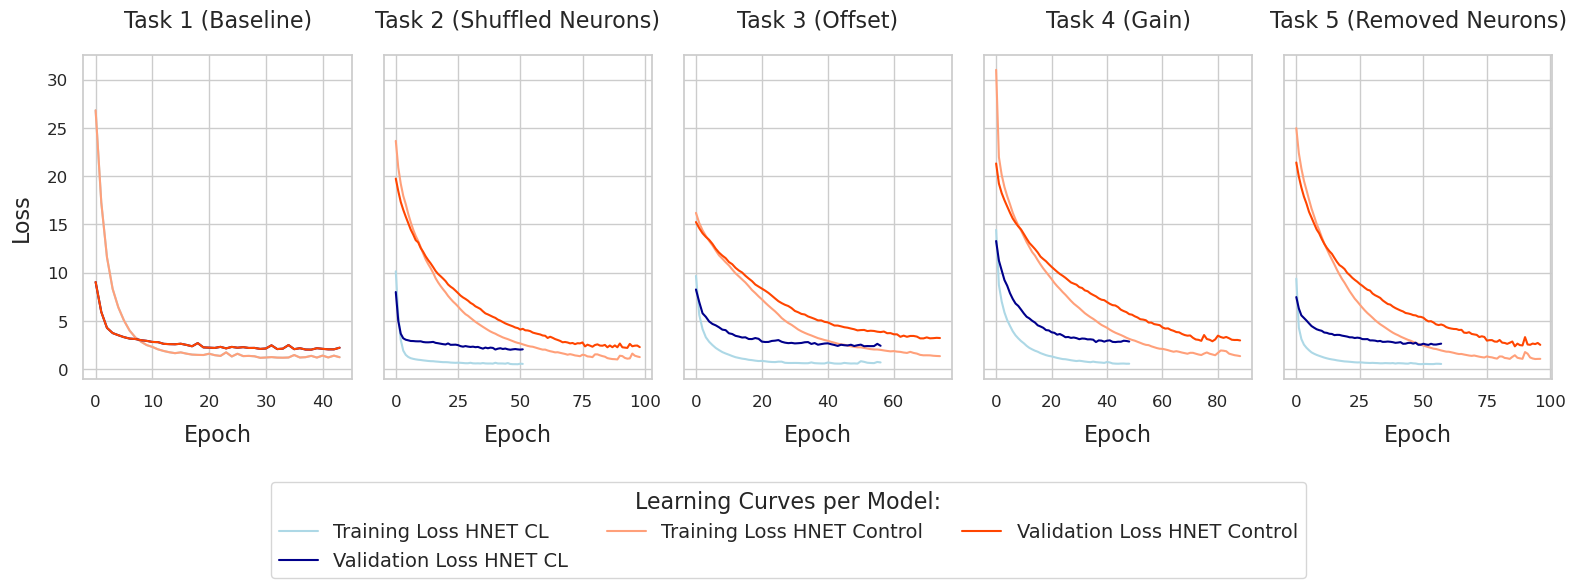

In [26]:
plot_learning_curves(df_exp0_hnet_new_v0, df_exp1_control_new, df_exp1_RNN)

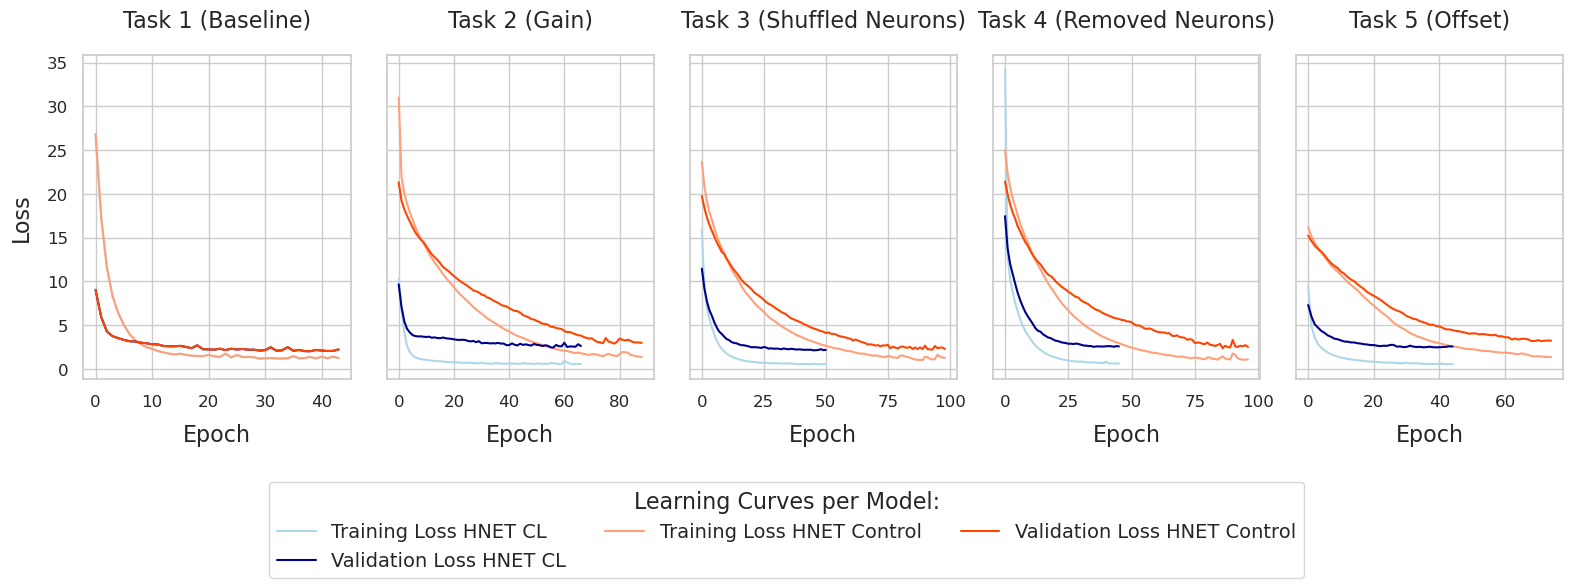

In [27]:
plot_learning_curves(df_exp0_hnet_new_v1, df_exp1_control, df_exp1_RNN_v1)

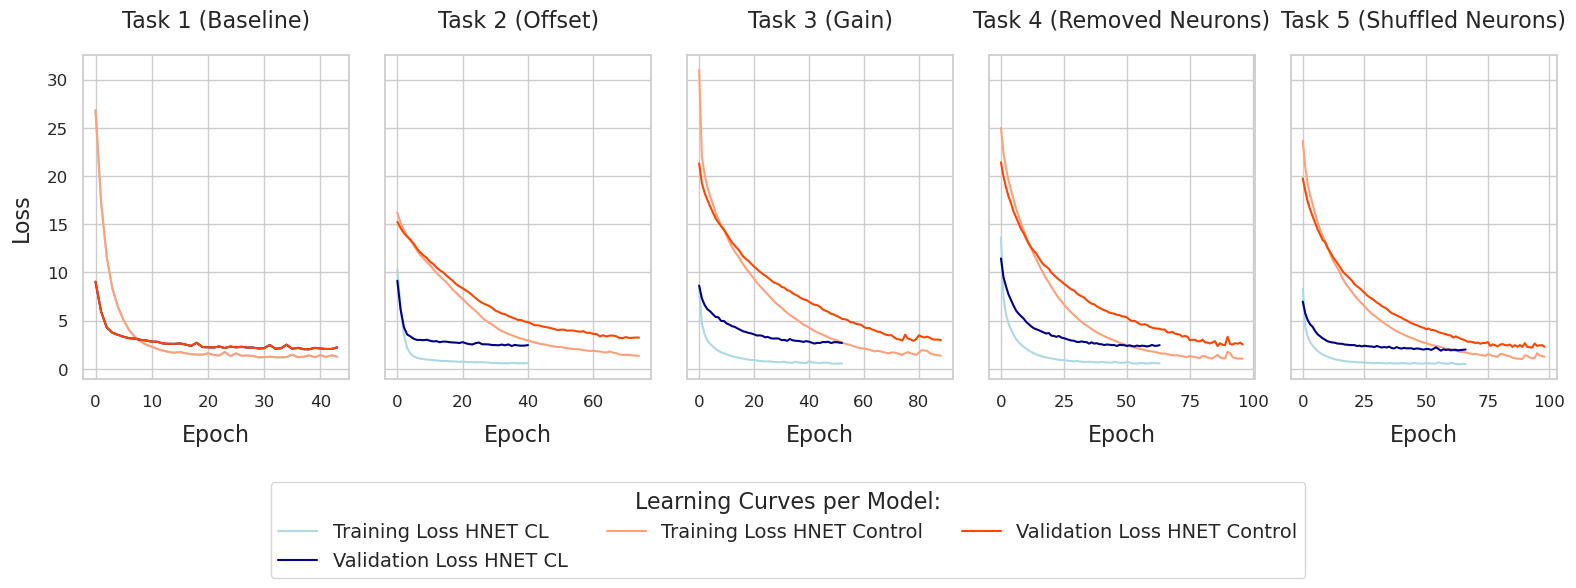

In [28]:
plot_learning_curves(df_exp0_hnet_new_v2, df_exp1_control, df_exp1_RNN_v2)

### Including the other methods: EWC and Fine Tuning.

#### Start with the first version

In [29]:
experiment1_EWC_v0 = 'Experiment77'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v0 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v0)))

path_results_exp1_EWC_v0 = './Results/' + experiment1_EWC_v0
with open(os.path.join(path_results_exp1_EWC_v0 +'_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v0 = pickle.load(fp)

data_path_exp1_EWC_v0 = './Data/Sim_Data_'+'Experiment60_sorted_first5'+'.pkl'
with open(os.path.join(data_path_exp1_EWC_v0), 'rb') as fp:
    data_exp1_EWC_v0 = pickle.load(fp)

In [30]:
df_exp1_EWC_v0 = build_result_df(results_exp1_EWC_v0, data_exp1_EWC_v0, EWC = True)

In [31]:
df_exp1_EWC_plot_v0 = build_catas_forg_df(results_exp1_EWC_v0, \
    data_exp1_EWC_v0, 
    models_exp1_EWC_v0, 
    experiment1_EWC_v0, 
    model_type = 'EWC')

In [32]:
r2_ewc_v0 = df_exp1_EWC_plot_v0.loc[df_exp1_EWC_plot_v0.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v0.rename(columns={'R2': 'EWC Model'}, inplace=True)

### Second version

In [33]:
experiment1_EWC_v1 = 'Experiment92'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v1 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v1)))

path_results_exp1_EWC_v1 = './Results/' + experiment1_EWC_v1
with open(os.path.join(path_results_exp1_EWC_v1 + '_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v1 = pickle.load(fp)

data_path_exp1_EWC_v1 = './Data/Sim_Data_Experiment60_sorted_first5_v2' + '.pkl'
with open(os.path.join(data_path_exp1_EWC_v1), 'rb') as fp:
    data_exp1_EWC_v1 = pickle.load(fp)

df_exp1_EWC_v1 = build_result_df(results_exp1_EWC_v1, data_exp1_EWC_v1, EWC=True)
df_exp1_EWC_plot_v1 = build_catas_forg_df(results_exp1_EWC_v1, 
                                          data_exp1_EWC_v1, 
                                          models_exp1_EWC_v1, 
                                          experiment1_EWC_v1, 
                                          model_type='EWC')
r2_ewc_v1 = df_exp1_EWC_plot_v1.loc[df_exp1_EWC_plot_v1.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v1.rename(columns={'R2': 'EWC Model'}, inplace=True)

### Third version

In [34]:
experiment1_EWC_v2 = 'Experiment93'

path_to_ewc = './Models/Models_EWC'

models_exp1_EWC_v2 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v2)))

path_results_exp1_EWC_v2 = './Results/' + experiment1_EWC_v2

with open(os.path.join(path_results_exp1_EWC_v2 + '_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v2 = pickle.load(fp)

data_path_exp1_EWC_v2 = './Data/Sim_Data_Experiment60_sorted_first5_v3' + '.pkl'

with open(os.path.join(data_path_exp1_EWC_v2), 'rb') as fp:
    data_exp1_EWC_v2 = pickle.load(fp)

df_exp1_EWC_v2 = build_result_df(results_exp1_EWC_v2, data_exp1_EWC_v2, EWC=True)

df_exp1_EWC_plot_v2 = build_catas_forg_df(results_exp1_EWC_v2, 
                                          data_exp1_EWC_v2, 
                                          models_exp1_EWC_v2, 
                                          experiment1_EWC_v2, 
                                          model_type='EWC')

r2_ewc_v2 = df_exp1_EWC_plot_v2.loc[df_exp1_EWC_plot_v2.Model == 'Model_Task_4.pth'][['Name', 'R2']]

r2_ewc_v2.rename(columns={'R2': 'EWC Model'}, inplace=True)


### Now for the Fine Tuning version

In [35]:
# For v0
experiment1_FT_v0 = 'Experiment77'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v0 = np.sort(os.listdir(os.path.join(path_to_ft, 'Experiment77')))

path_results_exp1_FT_v0 = './Results/' + experiment1_FT_v0
with open(os.path.join(path_results_exp1_FT_v0 + '_FT.pkl'), 'rb') as fp:
    results_exp1_FT_v0 = pickle.load(fp)

data_path_exp1_FT_v0 = './Data/Sim_Data_Experiment60_sorted_first5' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v0), 'rb') as fp:
    data_exp1_FT_v0 = pickle.load(fp)

df_exp1_FT_v0 = build_result_df(results_exp1_FT_v0, data_exp1_FT_v0, EWC=True)
df_exp1_FT_plot_v0 = build_catas_forg_df(results_exp1_FT_v0, 
                                         data_exp1_FT_v0, 
                                         models_exp1_FT_v0, 
                                         experiment1_FT_v0, 
                                         model_type='FT')


r2_ft_v0 = df_exp1_FT_plot_v0.loc[df_exp1_FT_plot_v0.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v0.rename(columns={'R2': 'FT Model'}, inplace=True)

In [36]:
# For v1
experiment1_FT_v1 = 'Experiment92'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v1 = np.sort(os.listdir(os.path.join(path_to_ft, experiment1_FT_v1)))

path_results_exp1_FT_v1 = './Results/' + experiment1_FT_v1
with open(os.path.join(path_results_exp1_FT_v1 + '_FT.pkl'), 'rb') as fp:
    results_exp1_FT_v1 = pickle.load(fp)

data_path_exp1_FT_v1 = './Data/Sim_Data_Experiment60_sorted_first5_v2' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v1), 'rb') as fp:
    data_exp1_FT_v1 = pickle.load(fp)

df_exp1_FT_v1 = build_result_df(results_exp1_FT_v1, data_exp1_FT_v1, EWC=True)
df_exp1_FT_plot_v1 = build_catas_forg_df(results_exp1_FT_v1, 
                                         data_exp1_FT_v1, 
                                         models_exp1_FT_v1, 
                                         experiment1_FT_v1, 
                                         model_type='FT')
r2_ft_v1 = df_exp1_FT_plot_v1.loc[df_exp1_FT_plot_v1.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v1.rename(columns={'R2': 'FT Model'}, inplace=True)



In [37]:
# For v2
experiment1_FT_v2 = 'Experiment93'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v2 = np.sort(os.listdir(os.path.join(path_to_ft, experiment1_FT_v2)))

path_results_exp1_FT_v2 = './Results/' + experiment1_FT_v2
with open(os.path.join(path_results_exp1_FT_v2 + '_FT.pkl'), 'rb') as fp:
    results_exp1_FT_v2 = pickle.load(fp)

data_path_exp1_FT_v2 = './Data/Sim_Data_Experiment60_sorted_first5_v3' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v2), 'rb') as fp:
    data_exp1_FT_v2 = pickle.load(fp)

df_exp1_FT_v2 = build_result_df(results_exp1_FT_v2, data_exp1_FT_v2, EWC= True)
df_exp1_FT_plot_v2 = build_catas_forg_df(results_exp1_FT_v2, 
                                         data_exp1_FT_v2, 
                                         models_exp1_FT_v2, 
                                         experiment1_FT_v2, 
                                         model_type='FT')
r2_ft_v2 = df_exp1_FT_plot_v2.loc[df_exp1_FT_plot_v2.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v2.rename(columns={'R2': 'FT Model'}, inplace=True)

### Plotting the comparison barplot between models

In [38]:
r2_control_v0 =df_exp1_control_new[['Dataset', 'R2_hnet']]
r2_control_v0.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
r2_hnet_during_v0 = df_exp0_hnet_new_v0[['Dataset', 'R2_hnet', 'True_Task']]
r2_hnet_during_v0.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)
r2_hnet_end_v0 = pd.DataFrame(df_exp0_v0.loc[df_exp0_v0.Model == 'Model_Task_4.pth'].groupby(['Name','Dataset'])['R2'].mean().reset_index())
r2_hnet_end_v0.rename(columns={'R2': 'HNET'}, inplace=True)

/tmp/ipykernel_1426608/4062593693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_control_v0.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
/tmp/ipykernel_1426608/4062593693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_hnet_during_v0.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)


In [39]:
comparison_table_v0 = r2_hnet_end_v0.merge(r2_hnet_during_v0, on = ['Dataset'])
comparison_table_v0 = comparison_table_v0.merge(r2_control_v0, on = ['Dataset'])
comparison_table_v0 = comparison_table_v0.sort_values(by='True_Task')
comparison_table_v0 = comparison_table_v0.merge(r2_ewc_v0, on = ['Name'])
comparison_table_v0 = comparison_table_v0.merge(r2_ft_v0, on = ['Name'])

In [42]:
def plot_comparison(df):

    #set_plot_style()

    # Melting the DataFrame to have a suitable format for plotting
    df_melted = df.melt(id_vars=['Name'], value_vars=['HNET', 'HNET During', 'Single Task Model', 'EWC Model', 'FT Model'],
                        var_name='Model', value_name='R2_Score')
    

    # Custom colors for the models
    custom_colors = [
        '#87CEEB',  # light blue
        '#FFA07A',  # light salmon (orange)
        '#9370DB',  # medium purple
        #'#FF69B4',  # hot pink
        '#FFB6C1',  #Lavender Blush: #FFF0F5
        '#20908d'   # teal   
    ]

    # Setting the plot style
    #sns.set(style="whitegrid")

    # Creating the bar plot
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(
        data=df_melted,
        x='Name',
        y='R2_Score',
        hue='Model',
        #palette=custom_colors
    )

    # Adding title and labels
    #bar_plot.set_title('Comparison of R² Scores for Different Models per Task')
    bar_plot.set_xlabel('Tested Task')
    bar_plot.set_ylabel('R² Score')
    plt.legend(title='Model',  loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    # Setting y-axis limits
    bar_plot.set(ylim=(-0.2, 0.9))

    # Display the plot
    plt.show()

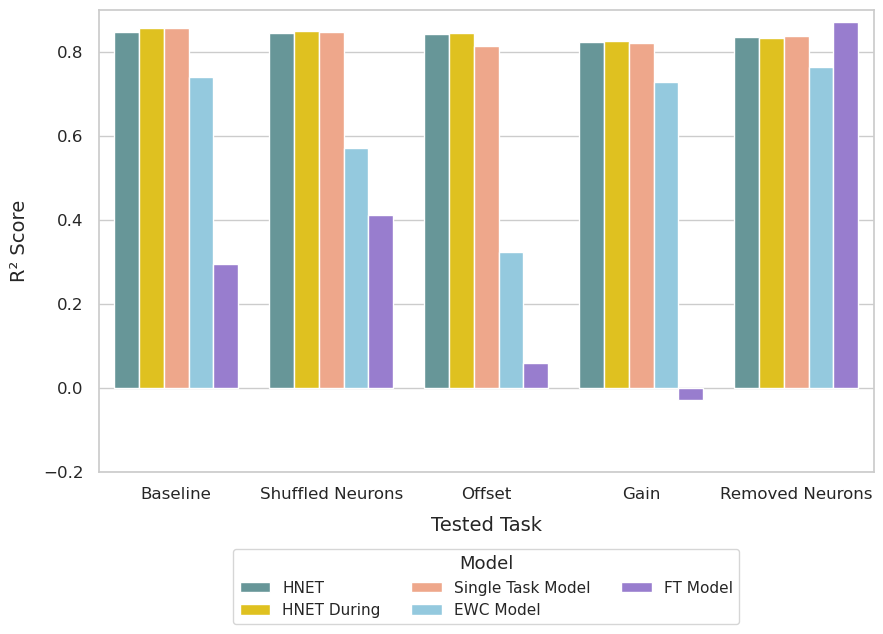

In [43]:
plot_comparison(comparison_table_v0)

/tmp/ipykernel_514939/1253349907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_control_v1.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
/tmp/ipykernel_514939/1253349907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_hnet_during_v1.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)


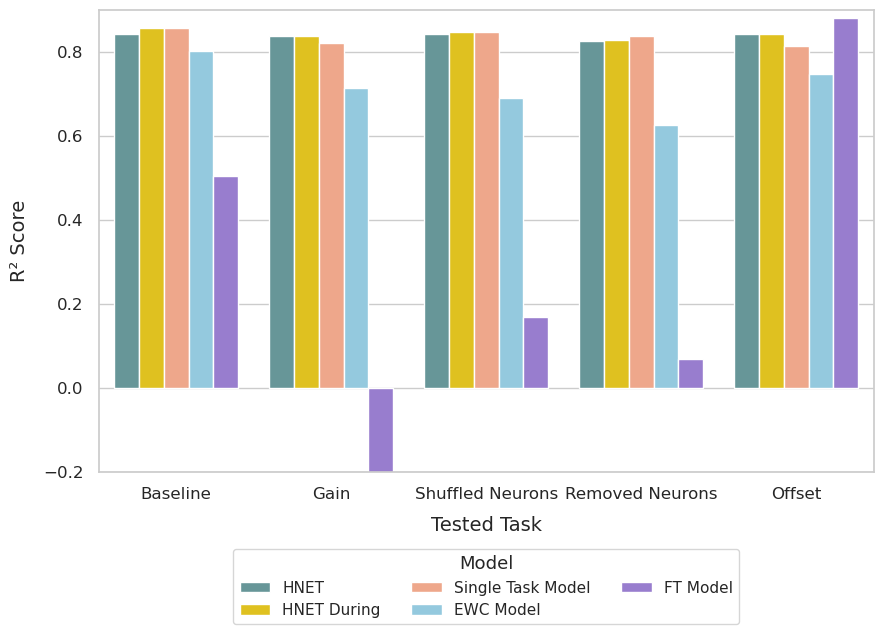

In [42]:
# Preparing the data for version v1
r2_control_v1 = df_exp1_control_new[['Dataset', 'R2_hnet']]
r2_control_v1.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
r2_hnet_during_v1 = df_exp0_hnet_new_v1[['Dataset', 'R2_hnet', 'True_Task']]
r2_hnet_during_v1.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)
r2_hnet_end_v1 = pd.DataFrame(df_exp0_v1.loc[df_exp0_v1.Model == 'Model_Task_4.pth'].groupby(['Name','Dataset'])['R2'].mean().reset_index())
r2_hnet_end_v1.rename(columns={'R2': 'HNET'}, inplace=True)

comparison_table_v1 = r2_hnet_end_v1.merge(r2_hnet_during_v1, on=['Dataset'])
comparison_table_v1 = comparison_table_v1.merge(r2_control_v1, on=['Dataset'])
comparison_table_v1 = comparison_table_v1.sort_values(by='True_Task')
comparison_table_v1 = comparison_table_v1.merge(r2_ewc_v1, on=['Name'])
comparison_table_v1 = comparison_table_v1.merge(r2_ft_v1, on=['Name'])

plot_comparison(comparison_table_v1)


/tmp/ipykernel_514939/1755200647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_control_v2.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
/tmp/ipykernel_514939/1755200647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_hnet_during_v2.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)


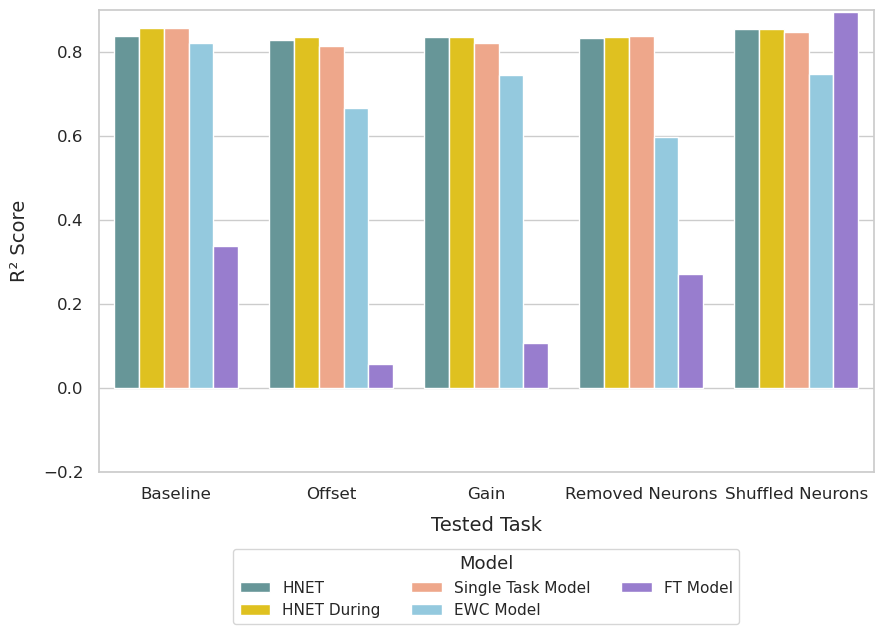

In [43]:
# Preparing the data for version v2
r2_control_v2 = df_exp1_control_new[['Dataset', 'R2_hnet']]
r2_control_v2.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
r2_hnet_during_v2 = df_exp0_hnet_new_v2[['Dataset', 'R2_hnet', 'True_Task']]
r2_hnet_during_v2.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)
r2_hnet_end_v2 = pd.DataFrame(df_exp0_v2.loc[df_exp0_v2.Model == 'Model_Task_4.pth'].groupby(['Name','Dataset'])['R2'].mean().reset_index())
r2_hnet_end_v2.rename(columns={'R2': 'HNET'}, inplace=True)

comparison_table_v2 = r2_hnet_end_v2.merge(r2_hnet_during_v2, on=['Dataset'])
comparison_table_v2 = comparison_table_v2.merge(r2_control_v2, on=['Dataset'])
comparison_table_v2 = comparison_table_v2.sort_values(by='True_Task')
comparison_table_v2 = comparison_table_v2.merge(r2_ewc_v2, on=['Name'])
comparison_table_v2 = comparison_table_v2.merge(r2_ft_v2, on=['Name'])

plot_comparison(comparison_table_v2)

# Experiment 2: Task order effect

In [44]:
def create_df_task_order(experiments, idx_start, idx_end):
    second_task = []
    third_task = []
    r2 = []

    for exp in range(idx_start, idx_end):
        experiment= experiments[exp]

        name = experiment['experiment_name']
        # Loading data
        data = experiment['data']
        data_dir = "./Data/"
        with open(os.path.join(data_dir, data +'.pkl'), 'rb') as fp:
            sets = pickle.load(fp)

        data2, data3 = list(sets.keys())[1:]
        second_task.append(data2)
        third_task.append(data3)

        path_to_hnets = './Models/Models_HNET'
        models_task2 = torch.load(os.path.join(path_to_hnets,name, 'Model_Task_2.pth'))

        W = models_task2(cond_id = int(2))
        main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  hidden_size = 300,
                            num_layers= 1,out_dims=2,  
                            dropout= 0.2,  LSTM_ = False)
        x_train, y_train, x_val, y_val, x_test, y_test = sets[data3]
        r2_, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
        
        r2.append(r2_)

    df_order = pd.DataFrame([second_task, third_task, r2]).T
    df_order.columns = ['Second Trained Task', 'Third Trained Task', 'R2 Third Task']
    return df_order

In [45]:
df_order_0 = create_df_task_order(experiments, 79, 91)
df_order_1 = create_df_task_order(experiments, 160, 172)
df_order_2 = create_df_task_order(experiments, 174, 186)
df_order_0_half2 = create_df_task_order(experiments, 186, 198)
df_order_1_half2 = create_df_task_order(experiments, 198, 210)
df_order_complete = pd.concat([df_order_0, df_order_1, df_order_2, df_order_0_half2, df_order_1_half2])

In [46]:
df = df_order_complete

# Mapping function
def map_perturbed_task(value):
    perturbed_task = value.split('_')[1]
    if perturbed_task == '0':
        return 'Baseline'
    elif perturbed_task == '1':
        return 'Removed'
    elif perturbed_task == '2':
        return 'Shuffled'
    elif perturbed_task == '3':
        return 'Gain'
    elif perturbed_task == '4':
        return 'Offset'
    else:
        return value

In [47]:
# Apply the mapping to the columns
df['Second Trained Task'] = df['Second Trained Task'].apply(map_perturbed_task)
df['Third Trained Task'] = df['Third Trained Task'].apply(map_perturbed_task)
df['R2 Third Task'] = pd.to_numeric(df['R2 Third Task'])

In [48]:
def plot_order_heatmap(df):
    # Create a new DataFrame for mean and std
    mean_data = df.pivot_table(index="Second Trained Task", columns="Third Trained Task", values="R2 Third Task", aggfunc='mean')
    std_data = df.pivot_table(index="Second Trained Task", columns="Third Trained Task", values="R2 Third Task", aggfunc='std')

    # Round the mean and std values
    mean_data = mean_data.round(2)
    std_data = std_data.round(5)


    # Prepare annotations with mean and std
    annotations = mean_data.copy().astype(str)  # Convert means to string
    for (i, j), val in np.ndenumerate(std_data):
        annotations.iat[i, j] += f' ± {val:.4f}'  # Append std to the mean

    # Generate the heatmap with enhanced styling
    plt.figure(figsize=(10, 8))

    sns.set(font_scale=1.2)  # Increase the font size

    # Define the minimum and maximum values for the colorscale
    vmin_value = 0.75  # Replace with your desired minimum value
    vmax_value = 0.9  # Replace with your desired maximum value

    # Create the heatmap with adjusted colorscale limits
    heatmap = sns.heatmap(mean_data, annot=annotations, cmap="magma_r", fmt="", linewidths=.5, 
                        cbar_kws={'label': 'R2 Value'}, vmin=vmin_value, vmax=vmax_value)

    # Customize the heatmap for better appearance
    #plt.title('Heatmap of R2 Values with Std Dev', fontsize=18)
    plt.xlabel('Third Trained Task', fontsize=14)
    plt.ylabel('Second Trained Task', fontsize=14)

    # Improve tick label appearance
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    # Adjust color bar
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)

    # Show the heatmap
    plt.tight_layout()
    plt.show()

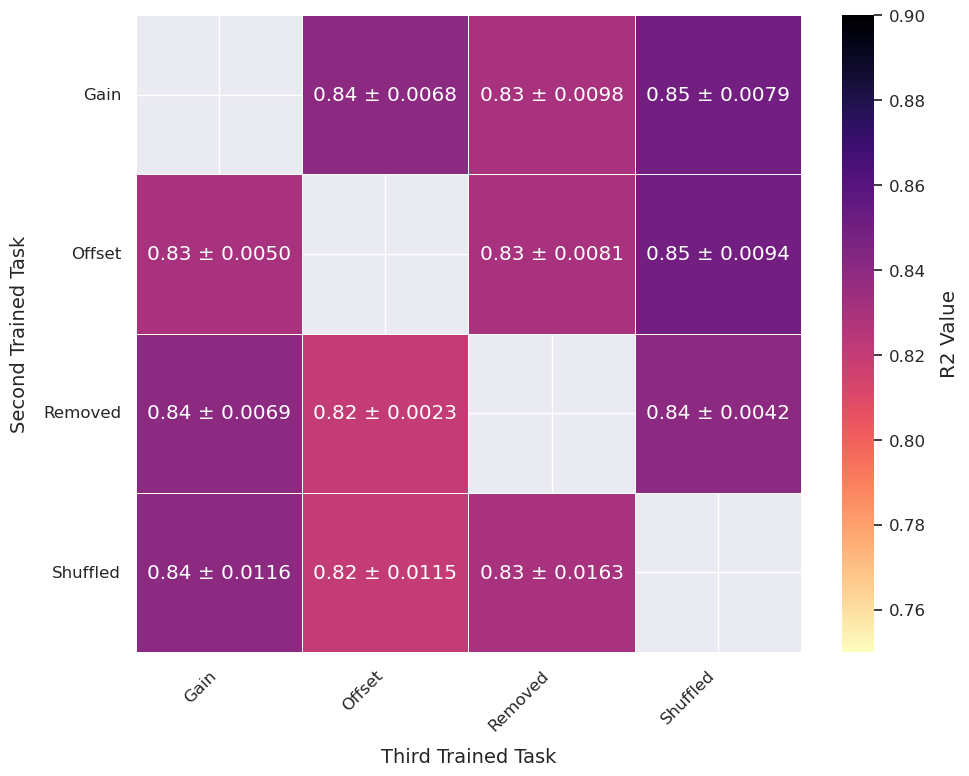

In [49]:
plot_order_heatmap(df)

# Experiment 3: Determining the minimum trial number to learn and identify tasks

Experiments from 76 to 128 (from 1 to 54 trials)

In [50]:
exp_num_trials = {'Experiment76' : 54,
                  'Experiment94': 1, 
                  'Experiment95': 5,
                  'Experiment96': 10, 
                  'Experiment97': 15, 
                  'Experiment98': 20, 
                  'Experiment99': 25, 
                  'Experiment100': 30, 
                  'Experiment101': 35, 
                  'Experiment102': 40,
                  'Experiment103': 45, 
                  'Experiment104': 50,
                  'Experiment105': 1, 
                  'Experiment106': 5,
                  'Experiment107': 10, 
                  'Experiment108': 15, 
                  'Experiment109': 20, 
                  'Experiment110': 25, 
                  'Experiment111': 30, 
                  'Experiment112': 35, 
                  'Experiment113': 40,
                  'Experiment114': 45, 
                  'Experiment115': 50,
                  'Experiment116': 54,
                  'Experiment117' : 1, 
                  'Experiment118': 5,
                  'Experiment119': 10,
                  'Experiment120' : 15, 
                  'Experiment121' : 20,
                  'Experiment122': 25,
                  'Experiment123': 30, 
                  'Experiment124' : 35,
                  'Experiment125' : 40,
                  'Experiment126': 45, 
                  'Experiment127' : 50,
                  'Experiment128' : 54,
                  }

In [51]:
df_results_min_learning = average_results(exp_num_trials)

In [52]:
def plot_min_trial_leaning(df):
    # Initialize the seaborn style
    sns.set_style("whitegrid")

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the accuracy on the primary y-axis
    sns.lineplot(data=df, x='Number Trials', y='Accuracy Task Detector', ax=ax1, marker='o', color='b')
    ax1.set_ylabel('Accuracy', color='b')

    # Create the secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='Number Trials', y='R2 Task Detector', ax=ax2, marker='x', color='r')
    ax2.set_ylabel('R2 Score', color='r')

    # Add title
    #plt.title('Accuracy and R2 Score vs. Number of Trials')

    # Show plot
    plt.show()

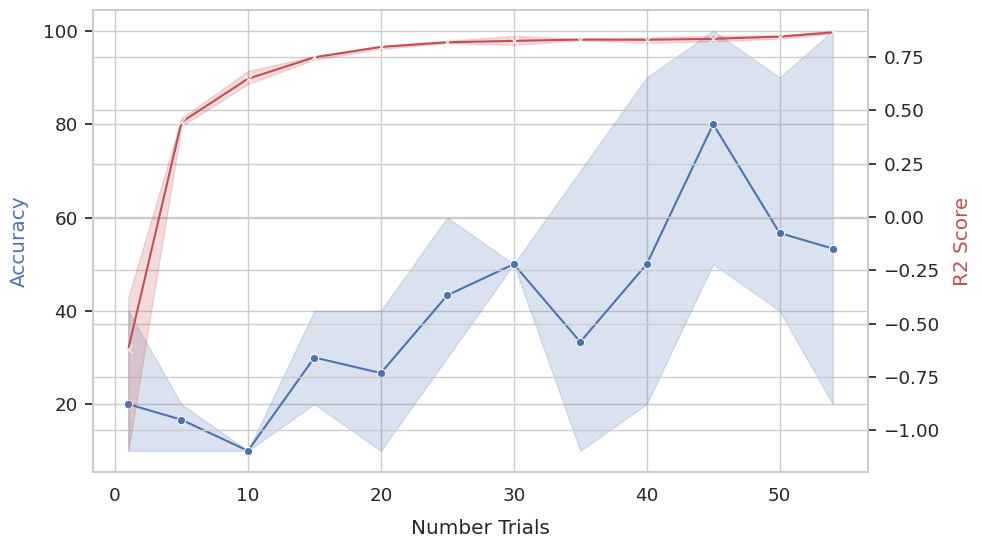

In [53]:
plot_min_trial_leaning(df_results_min_learning)

### Check here how many trials are needed for a task to be detected once it has been pre-trained.

In [54]:
exp3_min_infering = 'Experiment76'
data_name_exp3 = 'Experiment60_sorted'
data_path_exp3 = './Data/Sim_Data_'+data_name_exp3+'.pkl'
with open(os.path.join(data_path_exp3), 'rb') as fp:
    data_exp3 = pickle.load(fp)

In [55]:
df_exp3_1 = build_df_exp3(exp3_min_infering, data_exp3)
accuracy_by_num_trials = df_exp3_1.groupby(['Num Trials', 'True Task']).apply(lambda group: (group['True Task'] == group['Predicted Task']).mean())
accuracy_by_num_trials.name = 'Accuracy'
df_exp3_2 = pd.DataFrame(accuracy_by_num_trials.reset_index())
df_exp3 = df_exp3_1.merge(df_exp3_2, on = ['Num Trials', 'True Task'])

In [56]:
def plot_min_trial_infer(df):
    # Initialize the seaborn style
    sns.set_style("whitegrid")

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the accuracy on the primary y-axis
    sns.lineplot(data=df, x='Num Trials', y='Accuracy', ax=ax1, marker='o', color='b')
    ax1.set_ylabel('Accuracy', color='b')

    # Create the secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='Num Trials', y='R2', ax=ax2, marker='x', color='r')
    ax2.set_ylabel('R2 Score', color='r')

    # Add title
    #plt.title('Accuracy and R2 Score vs. Number of Trials')
    #plt.ylim([0.5,1])

    # Show plot
    plt.show()

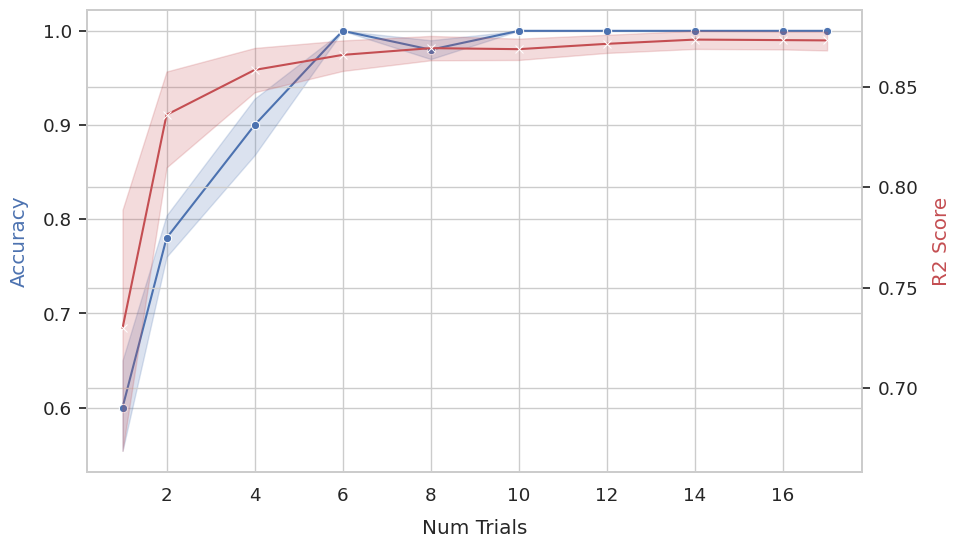

In [57]:
plot_min_trial_infer(df_exp3)

# Compute Forward Transfer

##### Method 1: We compare the performance of the model trained sequentially and task specific models (non CL). 

##### Comparing to the control experiment, also using HNETs

In [58]:
accuracies_CL = np.array(df_exp0_hnet_new_v0['R2_hnet'].values)[1:]
accuracies_control = np.array(df_exp1_control_new['R2_hnet'].values)[1:]
fwt = calculate_fwt(accuracies_CL, accuracies_control)
print(f"Forward Transfer (FWT): {fwt:.4f}")

Forward Transfer (FWT): 0.0083


##### Comparing to the Simple RNN model

In [59]:
accuracies_CL = np.array(df_exp0_hnet_new_v0['R2_hnet'].values)[1:]
accuracies_control = np.array(df_exp1_RNN['r2_test_hnet'].values)[1:]
fwt = calculate_fwt(accuracies_CL, accuracies_control)
print(f"Forward Transfer (FWT): {fwt:.4f}")

Forward Transfer (FWT): -0.0355


##### Now comparing the EWC approach to the control

In [60]:
accuracies_EWC = np.array(df_exp1_EWC_v0['R2_hnet'].values)[1:]
accuracies_control = np.array(df_exp1_control_new['R2_hnet'].values)[1:]
fwt = calculate_fwt(accuracies_EWC, accuracies_control)
print(f"Forward Transfer (FWT): {fwt:.4f}")

Forward Transfer (FWT): -0.0397


##### Now comparing the FT approach to the control

In [61]:
accuracies_FT = np.array(df_exp1_FT_v0['R2_hnet'].values)[1:]
accuracies_control = np.array(df_exp1_RNN['r2_test_hnet'].values)[1:]
fwt = calculate_fwt(accuracies_FT, accuracies_control)
print(f"Forward Transfer (FWT): {fwt:.4f}")

Forward Transfer (FWT): -0.0113


##### Method 2: Here we compare the performance of the hnet on task i before training task i, with the performance of a randomly initialized model (not trained) on task i. 

In [62]:
def create_table_FWT(df, experiment_name, data):
    model = []
    test_set = []
    r2_list = []
    data_name = []
    r2_random_mod = []
    path_to_models = './Models/Models_HNET'
    models_exp = np.sort(os.listdir(os.path.join(path_to_models, experiment_name)))
    for i,m in enumerate(models_exp):
        model_i = torch.load(os.path.join(path_to_models,experiment_name, m))
        for task,set in zip(df.True_Task, df.Dataset):
            perturbed_task = set.split('_')[1]

            if perturbed_task == '0':
                name = 'Baseline'
            elif perturbed_task == '1':
                name = 'Removed Neurons'    
            elif perturbed_task == '2':
                name = 'Shuffled Neurons'
            elif perturbed_task == '3':
                name = 'Gain' 
            elif perturbed_task == '4':
                name = 'Offset'

            pred_task = df.loc[df.Dataset == set].Predicted_Task.values


            if int(pred_task) == (i+1):
                W = model_i(cond_id = int(pred_task))
                main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  hidden_size = 300,
                                    num_layers= 1,out_dims=2,  
                                    dropout= 0.2,  LSTM_ = False).to(device)
                x_train, y_train, x_val, y_val, x_test, y_test = data[set]
                r2, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
                model.append(m)
                test_set.append(set)
                r2_list.append(r2)
                data_name.append(name)    

                #########################
                ### Now define a random model and compute the R2 before training for each task
                #########################
                
                ####### Define task detector model
                task_detector_model =  Causal_Simple_RNN(num_features=130, 
                                hidden_units= 300, 
                                num_layers = 1, 
                                out_dims = 2,
                                dropout = 0.2).to(device)
        

                #### Defining the template, main and hnet models and initializing them
                
                # We can use the task detector as a template for the main model
                param_shapes = [p.shape for p in list(task_detector_model.parameters())]

                num_conditions = 60 # we want more possible conditions than what we can reach
                size_task_embedding = 8 # seemed to work well 

                hnet = HMLP(param_shapes, uncond_in_size=0,
                    cond_in_size=size_task_embedding,
                    layers=[13], 
                    num_cond_embs=num_conditions).to(device)

                for param in hnet.parameters():
                    param.requires_grad = True

                W_random = hnet(cond_id = int(pred_task))
                r2_random, _ = calc_explained_variance_mnet(x_test, y_test, W_random, main_net)
                r2_random_mod.append(r2_random)

    df_forward_trans = pd.DataFrame({ 'Model':model,
                    'Name' : data_name,
                    'Dataset':test_set,
                    'R2_CL': r2_list,
                    'R2_Random': r2_random_mod})
    
    return df_forward_trans


In [63]:
fwt = 0

for i in range(20):
    df_forward_trans = create_table_FWT(df_exp0_hnet_v0, experiment0_hnet_v0, data_exp0_v0)
    accuracies_CL_before = np.array(df_forward_trans['R2_CL'].values)
    accuracies_control_random = np.array(df_forward_trans['R2_Random'].values)
    fwt_i = calculate_fwt(accuracies_CL_before, accuracies_control_random)
    fwt += fwt_i

fwt = fwt/20
print(f"Forward Transfer (FWT): {fwt:.4f}")

Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hype

##### Now for EWC method

In [64]:
def create_table_FWT_EWC(df, experiment_name, data):
    model = []
    test_set = []
    r2_list = []
    data_name = []
    r2_random_mod = []
    path_to_models = './Models/Models_EWC'
    models_exp = np.sort(os.listdir(os.path.join(path_to_models, experiment_name)))
    for i,m in enumerate(models_exp):
        model_i = torch.load(os.path.join(path_to_models,experiment_name, m))
        for task,set in zip(df.True_Task, df.Dataset):
            perturbed_task = set.split('_')[1]

            if perturbed_task == '0':
                name = 'Baseline'
            elif perturbed_task == '1':
                name = 'Removed Neurons'    
            elif perturbed_task == '2':
                name = 'Shuffled Neurons'
            elif perturbed_task == '3':
                name = 'Gain' 
            elif perturbed_task == '4':
                name = 'Offset'

            pred_task = df.loc[df.Dataset == set].Predicted_Task.values


            if int(pred_task) == (i+1):
                x_train, y_train, x_val, y_val, x_test, y_test = data[set]
                y_hat, y_true,train_score, v_score, test_score = eval_model( x_train, y_train,
                                                                        x_val, y_val,
                                                                        x_test, y_test, 
                                                                        model_i, 
                                                                        metric = 'r2')   
                
                model.append(m)
                test_set.append(set)
                r2_list.append(test_score)
                data_name.append(name)    

                ### Now define a random model and compute the R2 before training for each task
                num_features = x_train.shape[2]
                out_dims = y_train.shape[2]
                Simple_RNN =  Causal_Simple_RNN(num_features=num_features, 
                                hidden_units= 300, 
                                num_layers = 1, 
                                out_dims = out_dims,
                                dropout = 0.2).to(device)
                y_hat, y_true,train_score, v_score, test_score = eval_model( x_train, y_train,
                                                                        x_val, y_val,
                                                                        x_test, y_test, 
                                                                        Simple_RNN, 
                                                                        metric = 'r2') 
                r2_random_mod.append(test_score)
                
    df_forward_trans = pd.DataFrame({ 'Model':model,
                    'Name' : data_name,
                    'Dataset':test_set,
                    'R2_CL': r2_list,
                    'R2_Random': r2_random_mod})
    
    return df_forward_trans


In [65]:
fwt = 0

for i in range(20):
    df_forward_trans = create_table_FWT_EWC(df_exp1_EWC_v0, experiment1_EWC_v0, data_exp1_EWC_v0)
    accuracies_CL_before = np.array(df_forward_trans['R2_CL'].values)
    accuracies_control_random = np.array(df_forward_trans['R2_Random'].values)
    fwt_i = calculate_fwt(accuracies_CL_before, accuracies_control_random)
    fwt += fwt_i

fwt = fwt/20
print(f"Forward Transfer (FWT): {fwt:.4f}")

Forward Transfer (FWT): 0.2599


##### Now for Fine Tuning method

In [66]:
fwt = 0

for i in range(20):
    df_forward_trans = create_table_FWT_EWC(df_exp1_FT_v0, experiment1_FT_v0, data_exp1_FT_v0)
    accuracies_CL_before = np.array(df_forward_trans['R2_CL'].values)
    accuracies_control_random = np.array(df_forward_trans['R2_Random'].values)
    fwt_i = calculate_fwt(accuracies_CL_before, accuracies_control_random)
    fwt += fwt_i

fwt = fwt/20
print(f"Forward Transfer (FWT): {fwt:.4f}")

Forward Transfer (FWT): 0.2618
